# Inspection of WEAVE first-light supercubes

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u


## 2. Read data

### select one dataset:

In [2]:
dataset = 1

In [3]:
plots = False

In [4]:
plots = True

Red arm:

In [5]:
if dataset == 1:
    hdu = fits.open('data/supercube_2963102-001.fit')

In [6]:
hdu.info()
wcs = WCS(hdu[1].header)
wavelength = wcs.spectral.pixel_to_world(np.arange(hdu[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function = hdu[5].data

Filename: data/supercube_2963102-001.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     468   ()      
  1  RED_DATA      1 ImageHDU        72   (176, 188, 7361)   float32   
  2  RED_IVAR      1 ImageHDU        72   (176, 188, 7361)   float32   
  3  RED_DATA_NOSS    1 ImageHDU        72   (176, 188, 7361)   float32   
  4  RED_IVAR_NOSS    1 ImageHDU        72   (176, 188, 7361)   float32   
  5  RED_SENSFUNC    1 ImageHDU        15   (7361,)   float32   
  6  RED_DATA_COLLAPSE3    1 ImageHDU        72   (176, 188)   float32   
  7  RED_IVAR_COLLAPSE3    1 ImageHDU        72   (176, 188)   float32   


### explore counts to define bright, medium, and faint regions:

In [139]:
mean_counts = np.nanmean(hdu[1].data, axis=0)  # same as hdu[6]
median_counts = np.nanmedian(hdu[1].data, axis=0)

mean_sky_map = np.nanmean(hdu[3].data-hdu[1].data, axis=0)
median_sky_map = np.nanmedian(hdu[3].data-hdu[1].data, axis=0)

mask_bright = mean_counts > mean_sky_map
mask_medium = (median_counts > median_sky_map) & (mean_counts <= mean_sky_map)
mask_faint = (mean_counts > 0) & (median_counts <= median_sky_map)
mask_all = mean_counts > 0

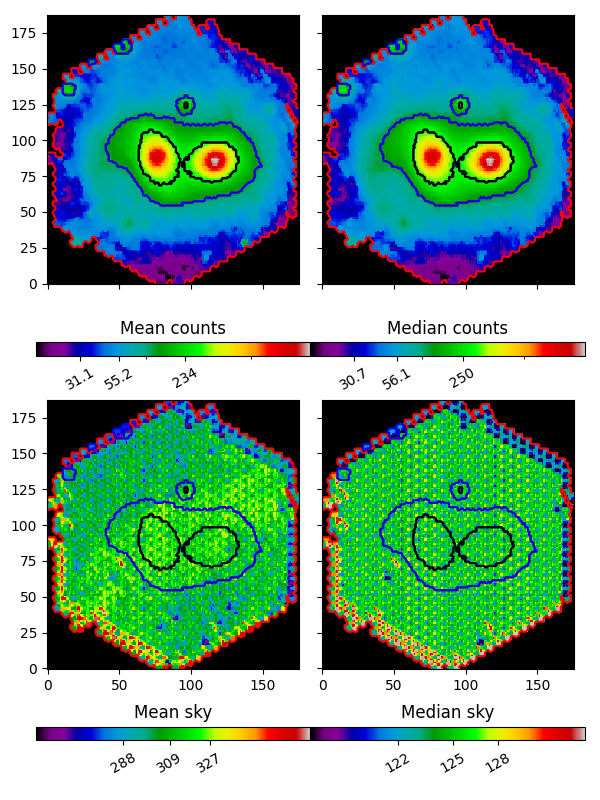

In [17]:
if plots:
    plt.close('counts')
    fig = plt.figure('counts', figsize=(6, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    
    def show_data(data, ax, title):
        p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
        im = ax.imshow(data,
                       interpolation='nearest', origin='lower',
                       cmap='nipy_spectral',
                       norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                      )
        ax.contour(mask_faint, levels=[0.5], colors=['r'])
        ax.contour(mask_medium, levels=[0.5], colors=['b'])
        ax.contour(mask_bright, levels=[0.5], colors=['k'])
        cb = fig.colorbar(im, ax=ax, orientation='horizontal')
        cb.ax.set_title(title)
        cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)
        
    show_data(mean_counts, ax[0, 0], 'Mean counts')
    show_data(median_counts, ax[0, 1], 'Median counts')
    show_data(mean_sky_map, ax[1, 0], 'Mean sky')
    show_data(median_sky_map, ax[1, 1], 'Median sky')
    
    plt.show()

### average SED within each region:

In [8]:
datacube = (hdu[3].data - hdu[1].data) * sensitivity_function[:, np.newaxis, np.newaxis]
sky_bright = np.nansum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
sky_medium = np.nansum(datacube*mask_medium[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_medium)
sky_faint = np.nansum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
sky_all = np.nansum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)

In [9]:
datacube = hdu[1].data * sensitivity_function[:, np.newaxis, np.newaxis]
SED_bright = np.nansum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_medium = np.nansum(datacube*mask_medium[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_medium, )
SED_faint = np.nansum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)

### broadband colors:

In [141]:
class Filter(object):
    
    def __init__(self, filename, col_wavelength=0, col_response=1):
        self.wavelength, self.response = np.loadtxt(filename, usecols=(col_wavelength, col_response), unpack=True)        
        self.norm_AB =  np.trapz(3631/3.34e4 * self.response/self.wavelength, self.wavelength)
        self.pivot_wavelength =  np.sqrt(
            np.trapz(self.response, self.wavelength) / np.trapz(self.response/self.wavelength**2, self.wavelength))
        
    def m_AB(self, F_lambda):
        """F_lambda in erg/s/cm^2/AA"""
        return -2.5*np.log10(np.trapz(self.wavelength*F_lambda*self.response, self.wavelength) / self.norm_AB)

g = Filter('sdss-filters/g.dat', 0, 2)
r = Filter('sdss-filters/r.dat', 0, 2)
i = Filter('sdss-filters/i.dat', 0, 2)
z = Filter('sdss-filters/z.dat', 0, 2)

In [109]:
#norm_r_AB = np.trapz(r_filter[:, 1]*3631/3.34e4/r_filter[:, 0], r_filter[:, 0])
weight_r_AB = np.interp(wavelength, r_filter[:, 0], r_filter[:, 1])
norm_r_AB = np.trapz(weight_r_AB*3631/3.34e4/wavelength, wavelength)
pivot_r = np.sqrt(np.trapz(r_filter[:, 1], r_filter[:, 0]) / np.trapz(r_filter[:, 1]/r_filter[:, 0]**2, r_filter[:, 0]))
r_bright = -2.5*np.log10(np.trapz(wavelength*SED_bright*weight_r_AB, wavelength) / norm_r_AB)
r_medium = -2.5*np.log10(np.trapz(wavelength*SED_medium*weight_r_AB, wavelength) / norm_r_AB)
r_faint = -2.5*np.log10(np.trapz(wavelength*SED_faint*weight_r_AB, wavelength) / norm_r_AB)

In [110]:
weight_i_AB = np.interp(wavelength, i_filter[:, 0], i_filter[:, 1])
norm_i_AB = np.trapz(weight_i_AB*3631/3.34e4/wavelength, wavelength)
pivot_i = np.sqrt(np.trapz(i_filter[:, 1], i_filter[:, 0]) / np.trapz(i_filter[:, 1]/i_filter[:, 0]**2, i_filter[:, 0]))
i_bright = -2.5*np.log10(np.trapz(wavelength*SED_bright*weight_i_AB, wavelength) / norm_i_AB)
i_medium = -2.5*np.log10(np.trapz(wavelength*SED_medium*weight_i_AB, wavelength) / norm_i_AB)
i_faint = -2.5*np.log10(np.trapz(wavelength*SED_faint*weight_i_AB, wavelength) / norm_i_AB)

In [111]:
weight_z_AB = np.interp(wavelength, z_filter[:, 0], z_filter[:, 1])
norm_z_AB = np.trapz(weight_z_AB*3631/3.34e4/wavelength, wavelength)
pivot_z = np.sqrt(np.trapz(z_filter[:, 1], z_filter[:, 0]) / np.trapz(z_filter[:, 1]/z_filter[:, 0]**2, z_filter[:, 0]))
z_bright = -2.5*np.log10(np.trapz(wavelength*SED_bright*weight_z_AB, wavelength) / norm_z_AB)
z_medium = -2.5*np.log10(np.trapz(wavelength*SED_medium*weight_z_AB, wavelength) / norm_z_AB)
z_faint = -2.5*np.log10(np.trapz(wavelength*SED_faint*weight_z_AB, wavelength) / norm_z_AB)

### visual inspection (raw counts):

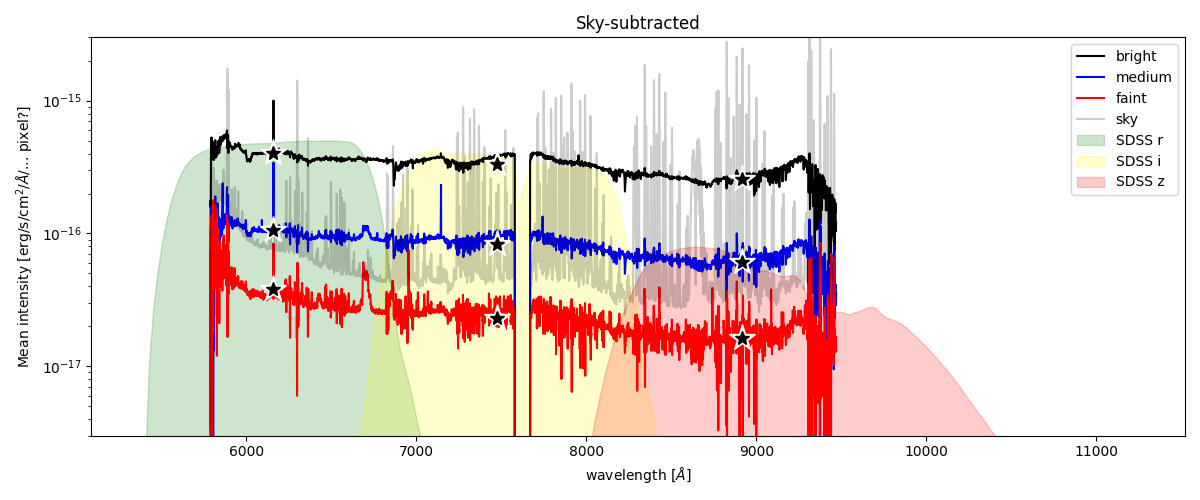

In [136]:
if plots:
    plt.close('spectra')
    fig = plt.figure('spectra', figsize=(12, 5))
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    fig.set_tight_layout(True)

    ax[0, 0].set_title(r'Sky-subtracted')
    ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')
    ax[0, 0].plot(wavelength, SED_bright, c='k', label='bright')
    ax[0, 0].plot(wavelength, SED_medium, c='b', label='medium')
    ax[0, 0].plot(wavelength, SED_faint, c='r', label='faint')
    ax[0, 0].plot(wavelength, sky_all, c='k', alpha=.2, label='sky')
    #ax[0, 0].fill_between(wavelength, mean_SED-2*mean_error,  mean_SED+2*mean_error, color='k', alpha=.1)
    #ax[0, 0].plot(wavelength, mean_error, c='k', alpha=.2, ls=':', label='1/sqrt(mean inverse variance)')
    #ax[0, 0].fill_between(g_filter[:, 0], 1e-18, g_filter[:, 1]*1e-15, color='blue', alpha=.1, label='SDSS g')
    ax[0, 0].fill_between(r_filter[:, 0], 1e-18, r_filter[:, 1]*1e-15, color='green', alpha=.2, label='SDSS r')
    ax[0, 0].fill_between(i_filter[:, 0], 1e-18, i_filter[:, 1]*1e-15, color='yellow', alpha=.2, label='SDSS i')
    ax[0, 0].fill_between(z_filter[:, 0], 1e-18, z_filter[:, 1]*1e-15, color='red', alpha=.2, label='SDSS z')
    ax[0, 0].plot(pivot_r, 3631/3.34e4 * 10**(-.4*r_bright)/pivot_r**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_r, 3631/3.34e4 * 10**(-.4*r_medium)/pivot_r**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_r, 3631/3.34e4 * 10**(-.4*r_faint)/pivot_r**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_i, 3631/3.34e4 * 10**(-.4*i_bright)/pivot_i**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_i, 3631/3.34e4 * 10**(-.4*i_medium)/pivot_i**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_i, 3631/3.34e4 * 10**(-.4*i_faint)/pivot_i**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_z, 3631/3.34e4 * 10**(-.4*z_bright)/pivot_z**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_z, 3631/3.34e4 * 10**(-.4*z_medium)/pivot_z**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_z, 3631/3.34e4 * 10**(-.4*z_faint)/pivot_z**2, 'w*', ms=20)
    ax[0, 0].plot(pivot_r, 3631/3.34e4 * 10**(-.4*r_bright)/pivot_r**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_r, 3631/3.34e4 * 10**(-.4*r_medium)/pivot_r**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_r, 3631/3.34e4 * 10**(-.4*r_faint)/pivot_r**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_i, 3631/3.34e4 * 10**(-.4*i_bright)/pivot_i**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_i, 3631/3.34e4 * 10**(-.4*i_medium)/pivot_i**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_i, 3631/3.34e4 * 10**(-.4*i_faint)/pivot_i**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_z, 3631/3.34e4 * 10**(-.4*z_bright)/pivot_z**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_z, 3631/3.34e4 * 10**(-.4*z_medium)/pivot_z**2, 'k*', ms=10)
    ax[0, 0].plot(pivot_z, 3631/3.34e4 * 10**(-.4*z_faint)/pivot_z**2, 'k*', ms=10)
    ax[0, 0].legend()

    #ax[0, 1].set_title(r'Sky')
    #ax[0, 1].plot(wavelength, sky_bright, c='k', alpha=.2, label='bright')
    #ax[0, 1].plot(wavelength, sky_medium, c='b', alpha=.2, label='medium')
    #ax[0, 1].plot(wavelength, sky_faint, c='r', alpha=.2, label='faint')
    #ax[0, 1].plot(wavelength, sky_all, c='g', alpha=.2, label='all')
    #ax[0, 1].legend()

    ax[0, -1].set_yscale('log')
    ax[0, -1].set_ylim(3e-18, 3e-15)
    ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
    #ax[-1, 1].set_xlabel(r'wavelength [$\AA$]')
    plt.show()

In [75]:
3.34e4/3631 * 10**(-.4*i_bright)/wavelength**2

array([4.71377183e-14, 4.71295781e-14, 4.71214400e-14, ...,
       1.76245262e-14, 1.76226651e-14, 1.76208042e-14])

In [82]:
#norm_r_AB = np.trapz(r_filter[:, 1]*3631/3.34e4/r_filter[:, 0], r_filter[:, 0])
weight_r_AB = np.interp(wavelength, r_filter[:, 0], r_filter[:, 1])
norm_r_AB = np.trapz(weight_r_AB*3631/3.34e4/wavelength, wavelength)
pivot_r = np.sqrt(np.trapz(r_filter[:, 1], r_filter[:, 0]) / np.trapz(r_filter[:, 1]/r_filter[:, 0]**2, r_filter[:, 0]))
r_bright = -2.5*np.log10(np.trapz(wavelength*SED_bright*weight_r_AB, wavelength) / norm_r_AB)
r_medium = -2.5*np.log10(np.trapz(wavelength*SED_medium*weight_r_AB, wavelength) / norm_r_AB)
r_faint = -2.5*np.log10(np.trapz(wavelength*SED_faint*weight_r_AB, wavelength) / norm_r_AB)

In [83]:
print(r_bright, 3.34e4/3631 * 10**(-.4*r_bright) / pivot_r**2)
print(r_medium, 3.34e4/3631 * 10**(-.4*r_medium) / pivot_r**2)
print(r_faint, 3.34e4/3631 * 10**(-.4*r_faint) / pivot_r**2)

17.12119592802353 3.439208097551407e-14
18.586434444435728 8.919962900527224e-15
19.69581214306211 3.2107904948625877e-15


In [65]:
norm_i_AB = np.trapz(i_filter[:, 1]*3631/3.34e4/i_filter[:, 0], i_filter[:, 0])
#pivot_r = np.sqrt(np.trapz(r_filter[:, 1], r_filter[:, 0]) / np.trapz(r_filter[:, 1]/r_filter[:, 0]**2, r_filter[:, 0]))
pivot_i = np.sqrt(np.trapz(i_filter[:, 1], i_filter[:, 0]) / np.trapz(i_filter[:, 1]/i_filter[:, 0]**2, i_filter[:, 0]))
weight_i_AB = np.interp(wavelength, i_filter[:, 0], i_filter[:, 1])
i_bright = -2.5*np.log10(np.trapz(wavelength*SED_bright*weight_i_AB, wavelength) / norm_i_AB)
i_medium = -2.5*np.log10(np.trapz(wavelength*SED_medium*weight_i_AB, wavelength) / norm_i_AB)
i_faint = -2.5*np.log10(np.trapz(wavelength*SED_faint*weight_i_AB, wavelength) / norm_i_AB)

In [66]:
print(i_bright, 3.34e4/3631 * 10**(-.4*i_bright) / pivot_i**2)
print(i_medium, 3.34e4/3631 * 10**(-.4*i_medium) / pivot_i**2)
print(i_faint, 3.34e4/3631 * 10**(-.4*i_faint) / pivot_i**2)

16.912486335280242 2.8269160354831855e-14
18.423850463541445 7.026956386361582e-15
19.809897527133195 1.9604168768261607e-15


In [ ]:
print(r_bright, 3.34e4/3631 * 10**(-.4*r_bright) / pivot_r**2)
print(r_medium, 3.34e4/3631 * 10**(-.4*r_medium) / pivot_r**2)
print(r_faint, 3.34e4/3631 * 10**(-.4*r_faint) / pivot_r**2)

17.32743935857032 2.809045338412711e-14
18.792677874982523 7.28556676241243e-15
19.902055573608905 2.622480471197699e-15


In [68]:
norm_i_AB

0.006654491382579669

In [86]:
np.trapz(3631/3.34e4/wavelength*weight_r_AB, wavelength) / norm_r_AB

1.0

In [96]:
10**(-.4*r_faint) * 3631/3.34e4 /wavelength**2

array([4.29138815e-17, 4.29064707e-17, 4.28990619e-17, ...,
       1.60452575e-17, 1.60435632e-17, 1.60418691e-17])

In [ ]:
10**(-.4*r_faint) * 3.34e4/3631/wavelength**2

array([3.63110020e-15, 3.63047315e-15, 3.62984626e-15, ...,
       1.35764782e-15, 1.35750446e-15, 1.35736111e-15])